##### Copyright 2018 The TensorFlow Authors.
> https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub
> https://www.tensorflow.org/tutorials/images/transfer_learning
##### Translated and editted by Tan Siqi, Chen Paizhong, Xiong Anjie

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## 引入依赖

In [2]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

%load_ext tensorboard

## 迁移学习方法

针对小数据集、自定标签的状况，采用迁移学习的方法，以复用特定网络结构在大数据集上提取的有意义特征。本次从在ImageNet上预训练的MobileNetV2模型开始，训练适于给定问题的分类器。

### 数据集

从dataset文件夹中获取已预先分为训练集和验证集的数据集。

In [34]:
batch_size = 32
img_height = 224
img_width = 224
from tensorflow.keras.preprocessing import image_dataset_from_directory
dataset_dir = 'dataset/train'
"""
train_dir = 'dataset/train'
validation_dir = 'dataset/validation'
"""

all_data = image_dataset_from_directory(dataset_dir,
                                             shuffle=True,
                                             batch_size=batch_size,
                                             image_size=(img_height, img_width))
def is_val(x, y):
    return x % 5 == 0

def is_train(x, y):
    return not is_val(x, y)

recover = lambda x,y: y

train_ds = all_data.enumerate() \
                    .filter(is_train) \
                    .map(recover)
val_ds = all_data.enumerate() \
                    .filter(is_val) \
                    .map(recover)

"""
train_ds = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=batch_size,
                                             image_size=(img_height, img_width))

val_ds = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=batch_size,
                                                  image_size=(img_height, img_width))
"""

Found 1886 files belonging to 22 classes.


'\ntrain_ds = image_dataset_from_directory(train_dir,\n                                             shuffle=True,\n                                             batch_size=batch_size,\n                                             image_size=(img_height, img_width))\n\nval_ds = image_dataset_from_directory(validation_dir,\n                                                  shuffle=True,\n                                                  batch_size=batch_size,\n                                                  image_size=(img_height, img_width))\n'

输出整个数据集中的二十二个类名。

In [4]:
class_names = np.array(all_data.class_names)
print(class_names)

['ape' 'bear' 'bison' 'cat' 'chicken' 'cow' 'deer' 'dog' 'dolphin' 'duck'
 'eagle' 'fish' 'horse' 'lion' 'lobster' 'pig' 'rabbit' 'shark' 'snake'
 'spider' 'turkey' 'wolf']


将图像rgb值转化为浮点表示。

In [5]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

使用缓冲预提取从磁盘加载图像，以免造成 I/O 阻塞。

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


### 获取预训练模型

<a href="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" class="external">从TensorFlow Hub下载</a>MobileNetV2去除顶层分类层（head-less）的预训练模型。

In [8]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_model = mobilenet_v2

将得到的模型抽象成特征提取层，并冻结参数。

In [9]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

包裹完成的特征提取层会为每张图像生成1280维的特征向量表示。

In [10]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


### 增加顶层分类层

在顶层增加一个全连接层，用以充当自定义分类器。
One-Hot编码22个类别，本层将输出对应22个类别的“概率”。

In [11]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 22)                28182     
Total params: 2,286,166
Trainable params: 28,182
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
predictions = model(image_batch)

In [13]:
predictions.shape

TensorShape([32, 22])

### 训练模型

编译模型并进行log保存的设置。

In [14]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

训练模型。

In [15]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/10
47/47 [==============================] - 9s 104ms/step - loss: 1.6559 - acc: 0.5799 - val_loss: 0.5368 - val_acc: 0.8880
Epoch 2/10
47/47 [==============================] - 1s 30ms/step - loss: 0.3782 - acc: 0.9281 - val_loss: 0.2797 - val_acc: 0.9375
Epoch 3/10
47/47 [==============================] - 1s 28ms/step - loss: 0.2222 - acc: 0.9581 - val_loss: 0.1941 - val_acc: 0.9635
Epoch 4/10
47/47 [==============================] - 1s 27ms/step - loss: 0.1536 - acc: 0.9754 - val_loss: 0.1447 - val_acc: 0.9714
Epoch 5/10
47/47 [==============================] - 1s 29ms/step - loss: 0.1128 - acc: 0.9887 - val_loss: 0.1123 - val_acc: 0.9844
Epoch 6/10
47/47 [==============================] - 1s 30ms/step - loss: 0.0866 - acc: 0.9920 - val_loss: 0.0910 - val_acc: 0.9870
Epoch 7/10
47/47 [==============================] - 1s 28ms/step - loss: 0.0686 - acc: 0.9953 - val_loss: 0.0769 - val_acc: 0.9870
Epoch 8/10
47/47 [==============================] - 1s 28ms/step - loss: 0.0558 - 

在TensorBoard中观察训练过程。

In [16]:
%tensorboard --logdir logs/fit

<!-- <img class="tfo-display-only-on-site" src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/images/tensorboard_transfer_learning_with_hub.png?raw=1"/> -->

### 观察预测状况

挑选训练集中的一个batch，进行预测，以评估结果。

In [17]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

['dolphin' 'deer' 'pig' 'dolphin' 'bear' 'bear' 'deer' 'shark' 'pig'
 'lion' 'dog' 'eagle' 'snake' 'lobster' 'lobster' 'deer' 'eagle' 'snake'
 'turkey' 'horse' 'bison' 'wolf' 'wolf' 'wolf' 'eagle' 'deer' 'rabbit'
 'turkey' 'bear' 'lion' 'deer' 'lion']


作图。

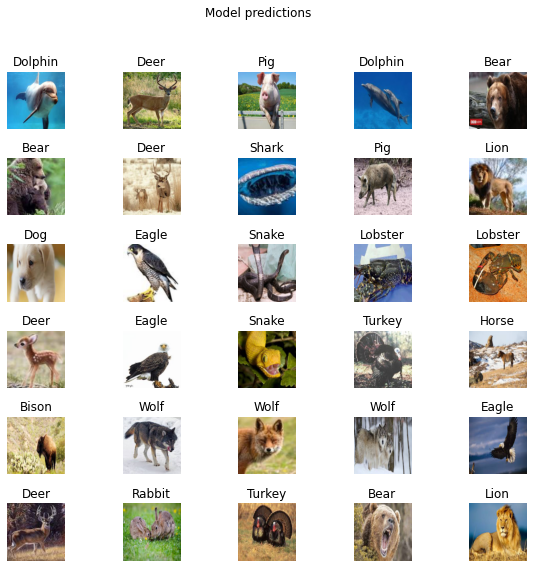

In [18]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

## 导出和重加载模型

存储模型以备利用。

In [19]:
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1633854705\assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1633854705\assets


'/tmp/saved_models/1633854705'

### 进行预测

In [20]:
reloaded = tf.keras.models.load_model(export_path)

读入无标签测试数据，进行预测。

In [21]:
img_b = []
for i in range(110):
    to_add_path = "dataset/test/"+str(i)+".png"
    img = tf.keras.utils.load_img(
        to_add_path,
        target_size=(img_height, img_width)
    )
    img = np.array(img)/255.
    img_b.append(img)
img_b = np.array(img_b, dtype=np.float32)
result_batch = model.predict(img_b)
reloaded_result_batch = reloaded.predict(img_b)

输出预测结果。

In [22]:
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]
print(reloaded_predicted_label_batch)

['horse' 'duck' 'ape' 'lion' 'cow' 'fish' 'turkey' 'wolf' 'rabbit' 'cow'
 'dog' 'cat' 'ape' 'fish' 'turkey' 'dog' 'chicken' 'horse' 'wolf' 'turkey'
 'dog' 'turkey' 'dolphin' 'shark' 'bear' 'duck' 'cat' 'dog' 'lion'
 'chicken' 'duck' 'shark' 'chicken' 'cat' 'snake' 'deer' 'spider' 'ape'
 'lion' 'deer' 'rabbit' 'lobster' 'ape' 'snake' 'snake' 'eagle' 'rabbit'
 'wolf' 'dog' 'lobster' 'shark' 'lobster' 'horse' 'bear' 'dolphin'
 'spider' 'dog' 'dolphin' 'pig' 'bison' 'spider' 'bear' 'spider' 'duck'
 'snake' 'fish' 'lobster' 'ape' 'dolphin' 'deer' 'bison' 'dog' 'deer'
 'dog' 'cow' 'lion' 'wolf' 'chicken' 'rabbit' 'bison' 'snake' 'eagle'
 'bison' 'turkey' 'dog' 'duck' 'turkey' 'dolphin' 'fish' 'wolf' 'dog'
 'lion' 'fish' 'lion' 'shark' 'dog' 'ape' 'dolphin' 'horse' 'horse'
 'chicken' 'horse' 'cow' 'cat' 'bear' 'lobster' 'pig' 'eagle' 'bison'
 'deer']


作图。

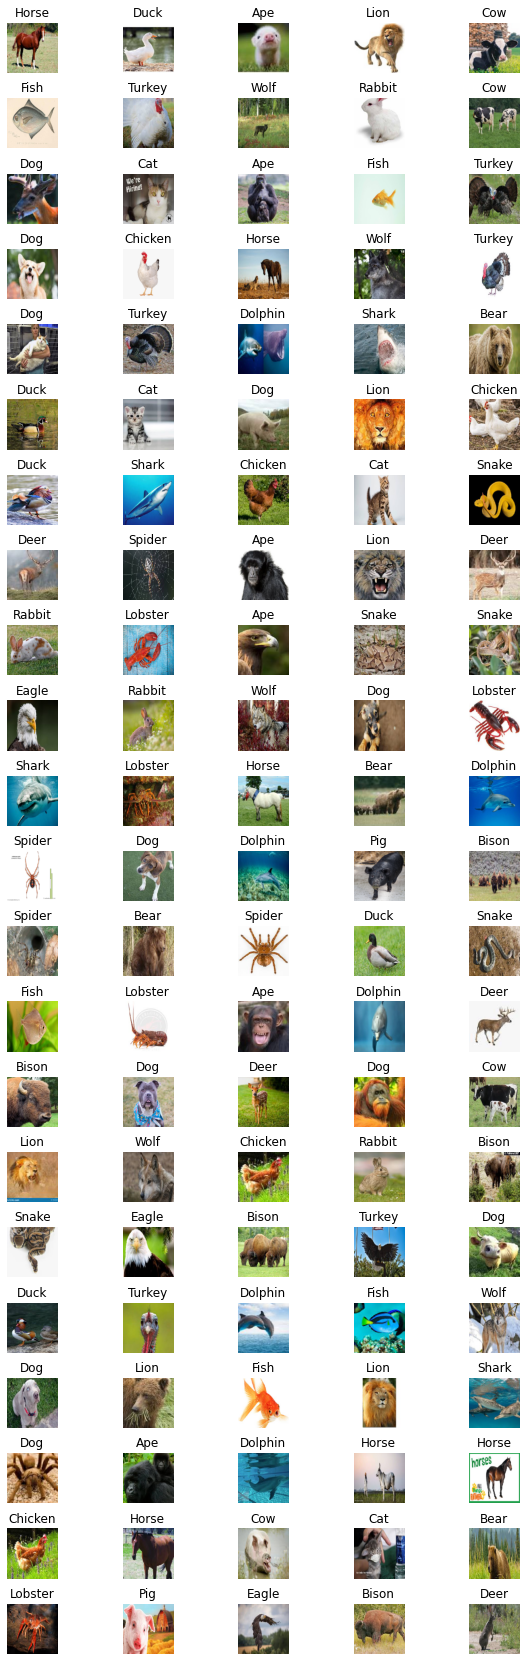

In [23]:
plt.figure(figsize=(10,30))
plt.subplots_adjust(hspace=0.5)
for n in range(110):
  plt.subplot(22,5,n+1)
  plt.imshow(img_b[n])
  plt.title(reloaded_predicted_label_batch[n].title())
  plt.axis('off')